# Decomposition

In this Notebook I tested different possibilities of differencing and decomposition with the purpose of making sure that our data is stationary. This is because we found out in our research that many models work better for stationary data and because the data needs to be stationary to find patterns between different data sources. The tests need to be done for all the feature we use in our final model.

Good website: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [42]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf

In [125]:
montel = pd.read_csv('montel.csv')

In [126]:
df = montel.set_index('Time')
df.index = pd.to_datetime(df.index)

# Original data

Text(0.5, 1.0, 'EEX Day-Ahead Market')

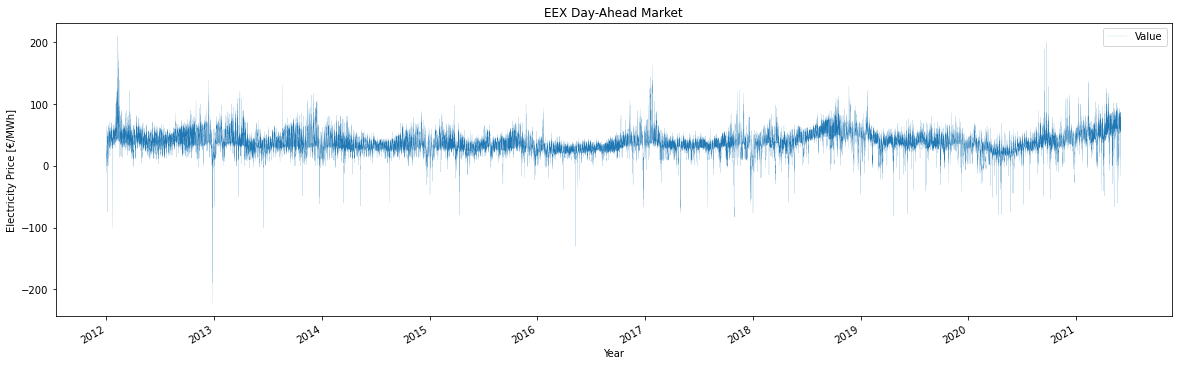

In [127]:
ax = df.plot(linewidth=0.1, figsize = (20, 6))
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

# Differenced data (subtract (t) - (t-1)

In [128]:
# automatic differencing (t) - (t-1)
differenced = df.diff(periods = 1)

In [129]:
diff = df.diff(12)

Text(0.5, 1.0, 'EEX Day-Ahead Market')

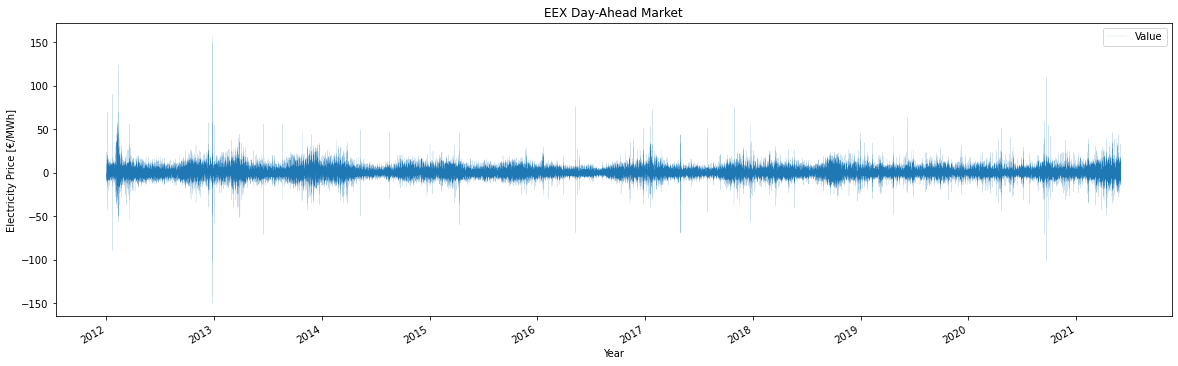

In [130]:
ax = differenced.plot(linewidth=0.1, figsize = (20, 6))
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

/opt/anaconda3/envs/AMI/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


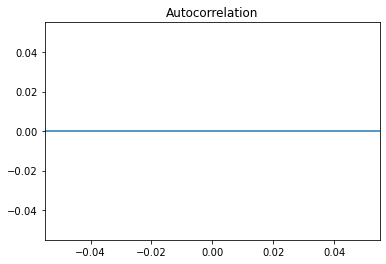

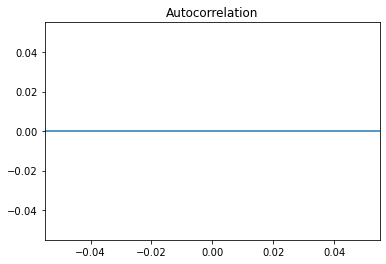

In [131]:
plot_acf(diff)

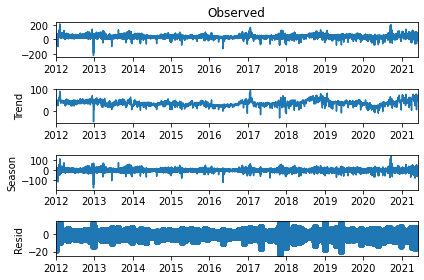

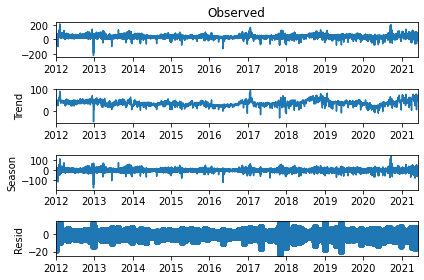

In [132]:
stl = STL(df, seasonal=3, period = 24)
res = stl.fit()
res.plot()

In [133]:
# plot decomposed data
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)

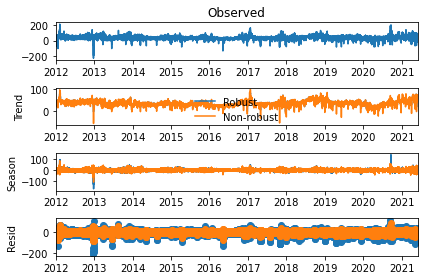

In [134]:
stl = STL(df, period=24, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(df, period=24, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust','Non-robust'])

# Stationarity

In [135]:
# stationarity test with a rolling window approach 
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24*7).mean()
    rolstd = timeseries.rolling(window=24*7).std()

    #Plot rolling statistics:
    plt.figure(figsize = (20, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, regression = 'ctt' ,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

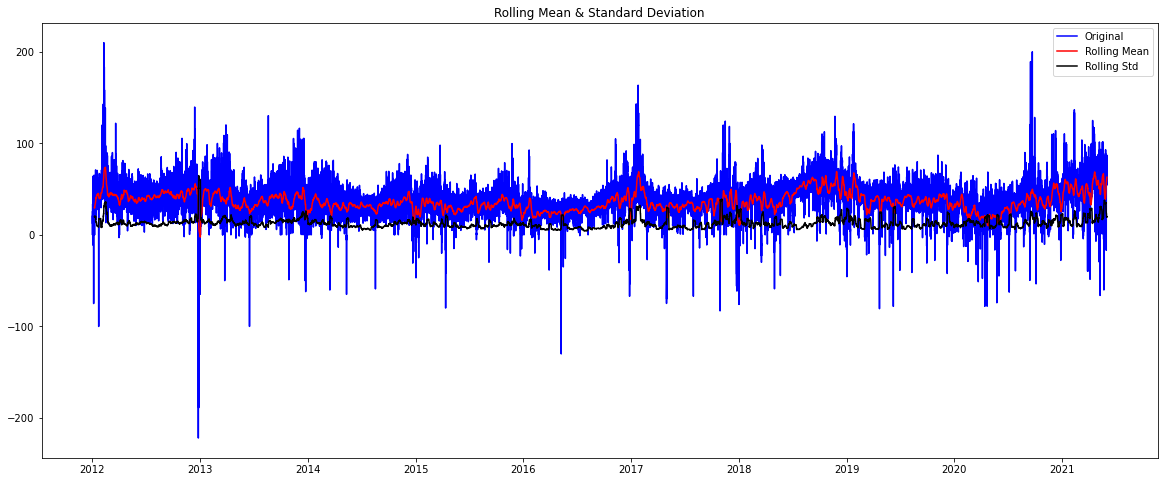

Results of Dickey-Fuller Test:
Test Statistic                   -20.811370
p-value                            0.000000
#Lags Used                        65.000000
Number of Observations Used    82494.000000
Critical Value (1%)               -4.371270
Critical Value (5%)               -3.832462
Critical Value (10%)              -3.553304
dtype: float64


In [136]:
test_stationarity(df)
# staionarity is fulfilled as the test statistic is 
#beneath the critical values and the p vaue is less than 0.05

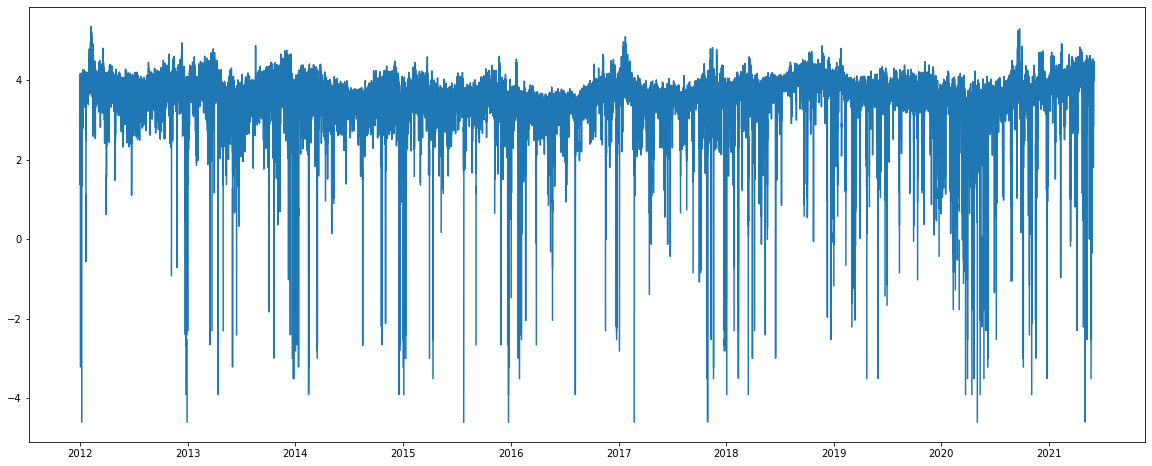

In [137]:
ts_log = np.log(df)
plt.figure(figsize = (20, 8))
plt.plot(ts_log)

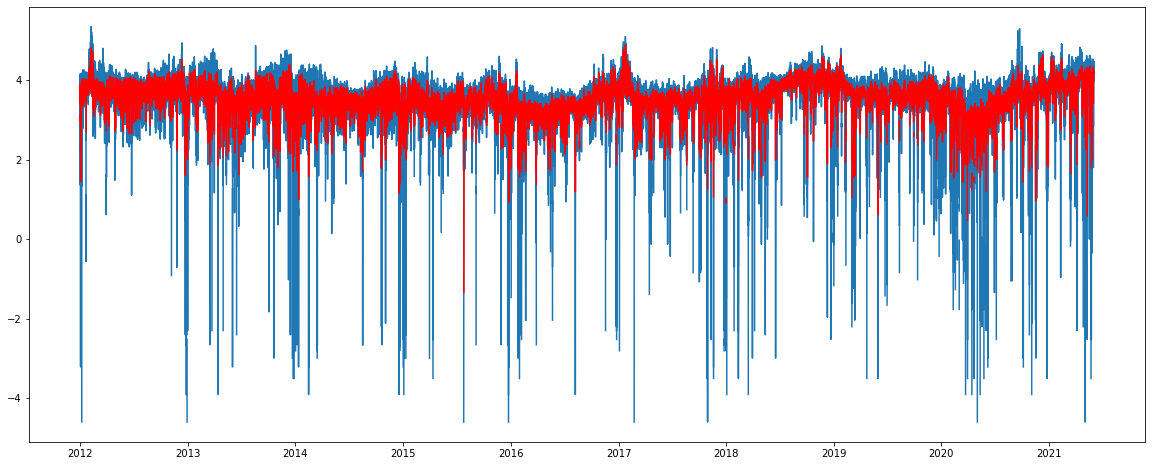

In [138]:
moving_avg = ts_log.rolling(window = 12).mean()
plt.figure(figsize = (20, 8))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

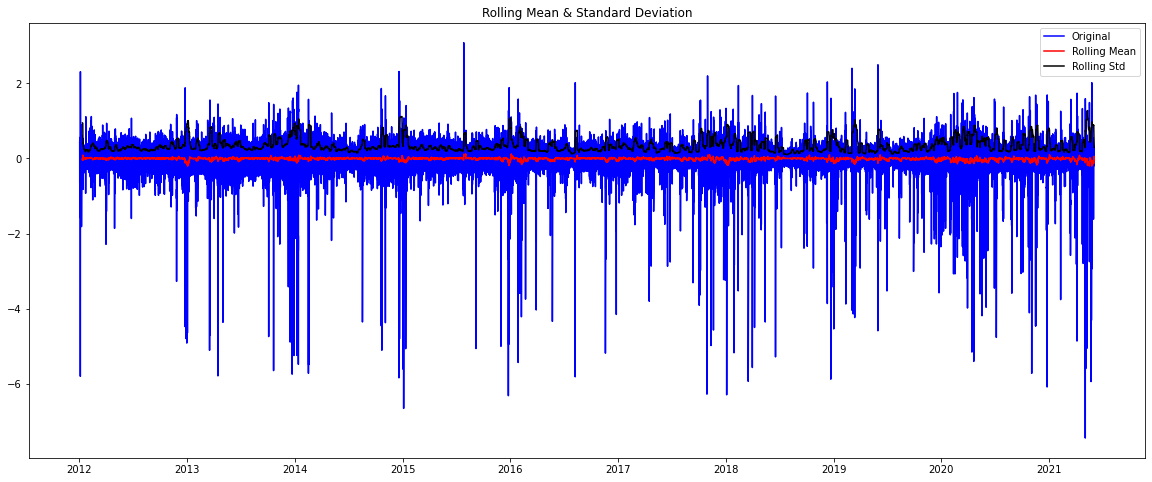

Results of Dickey-Fuller Test:
Test Statistic                   -44.609498
p-value                            0.000000
#Lags Used                        64.000000
Number of Observations Used    78861.000000
Critical Value (1%)               -4.371277
Critical Value (5%)               -3.832465
Critical Value (10%)              -3.553306
dtype: float64


In [139]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

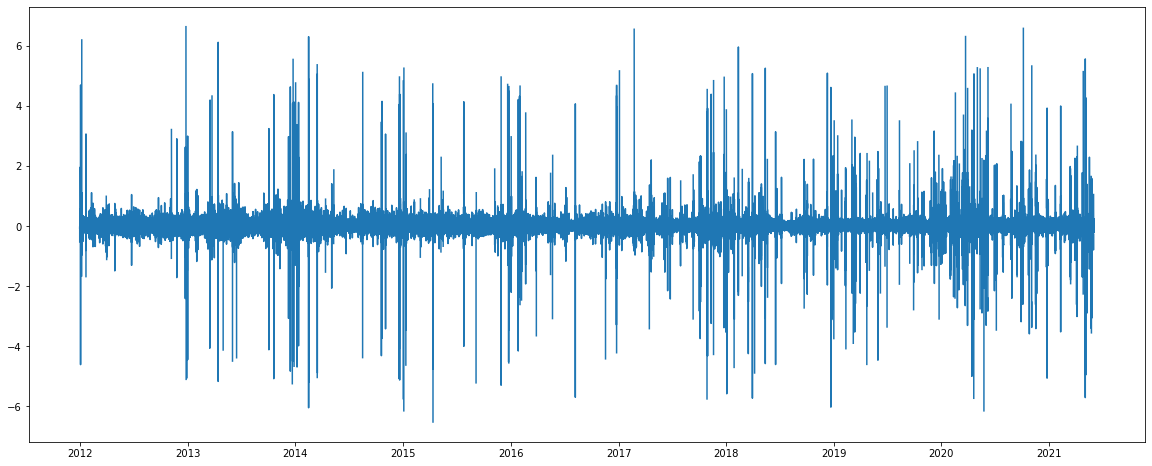

In [140]:
plt.figure(figsize = (20, 8))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [150]:
ts_log_diff.dropna(inplace=True)
print(ts_log_diff)
ts_log_diff.isna().sum()
ts_log_diff = ts_log_diff.fillna(method='ffill') 

                        Value
Time                         
2012-01-01 01:00:00 -0.060724
2012-01-01 02:00:00 -0.216924
2012-01-01 03:00:00 -0.175305
2012-01-01 04:00:00 -0.004393
2012-01-01 05:00:00 -0.516080
...                       ...
2021-06-01 19:00:00  0.088459
2021-06-01 20:00:00 -0.018157
2021-06-01 21:00:00 -0.056040
2021-06-01 22:00:00 -0.066644
2021-06-01 23:00:00 -0.115727

[81126 rows x 1 columns]


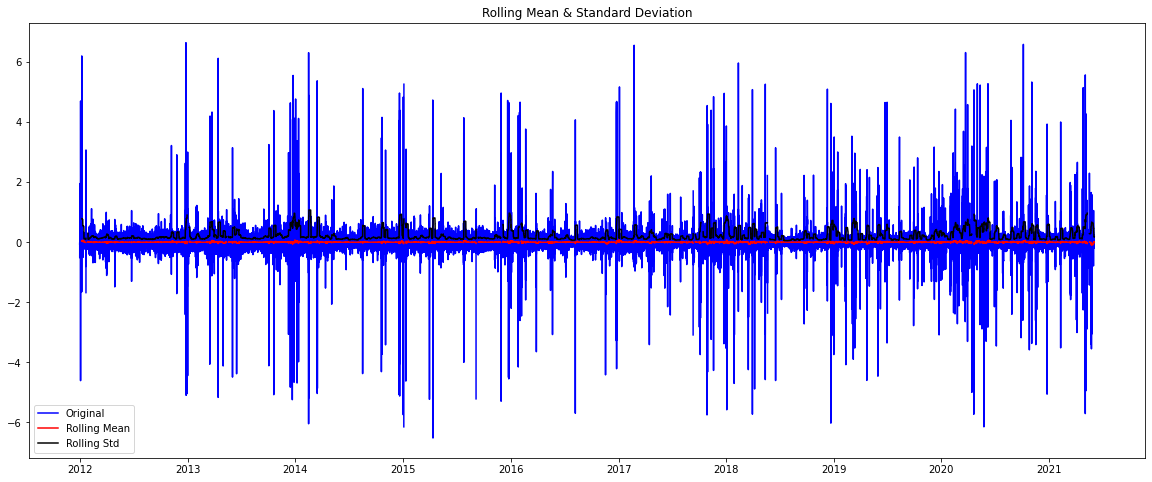

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [151]:
test_stationarity(ts_log_diff)